In [86]:
import Modules.SQcircuit_extensions as sq_ext
import Modules.figures as figs
import SQcircuit as sq
import numpy as np
import matplotlib.pyplot as plt
import importlib
from scipy.linalg import eigh
import qutip as qt
import sympy as sym
from joblib import Parallel, delayed, cpu_count

%matplotlib ipympl
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
plt.rcParams['text.usetex'] = False
importlib.reload(sq_ext)
importlib.reload(sq)
importlib.reload(figs)
np.set_printoptions(linewidth=300, formatter={'float': '{:.12f}'.format})

In [87]:
fF  = 1e-15
nH  = 1e-9
GHz = 1e9

# Study of the effective coupling beteewn qubits 1 and 3, mediated by qubit 2

In [88]:
n_eig = 4
nmax_r = 6
nmax_f = 10

CC_values = np.geomspace(1e-2, 1e0, 10)

In [5]:
CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, ω_r_1 = sq_ext.get_experimental_parameters('qubit_1')
CR_2, CF_2, LF_2, LR_2, EJ_2, Δ_2, ω_r_2 = sq_ext.get_experimental_parameters('qubit_2')
CR_3, CF_3, LF_3, LR_3, EJ_3, Δ_3, ω_r_3 = sq_ext.get_experimental_parameters('qubit_3')

φ_ext_1 = 0.5 +0.0265
φ_ext_2 = 0.5
φ_ext_3 = 0.5 +0.0295

params_1 = [CR_1, CF_1, LF_1, LR_1, EJ_1, Δ_1, φ_ext_1] 
params_2 = [CR_2, CF_2, LF_2, LR_2, EJ_2, Δ_2, φ_ext_2] 
params_3 = [CR_3, CF_3, LF_3, LR_3, EJ_3, Δ_3, φ_ext_3] 

Δs = [Δ_1, Δ_2, Δ_3]
# Δs = [0.05, 0.05, 0.05]
# Δs = [0,0,0]

# Qubit 1 - Coupler at operation point - Composite method

In [6]:
p1  = np.zeros([len(CC_values), 4, 4])
p2  = np.zeros([len(CC_values), 4, 4])
SWT = np.zeros([len(CC_values), 4, 4])

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)

    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_1, CF_1, CR_2, CF_2, only_inner=True, compensate_extra_cap=False, only_renormalization=False)
    C_inv = np.linalg.inv(C_mat)
    
    fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f, φ_ext = φ_ext_1)
    resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_1, nmax_f=nmax_f, φ_ext = φ_ext_2)
    resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2]
    Δs = [Δ_1, Δ_2]
    
    H_f1 = fluxonium_1.hamiltonian()
    H_r1 = resonator_1.hamiltonian()
    H_f2 = fluxonium_2.hamiltonian()
    H_r2 = resonator_2.hamiltonian()
    H_q1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δ_1)
    H_q2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δ_2)
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_q1, H_fluxonium=H_f1, H_resonator=H_r1, n_eig=4)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q1 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q1 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_q2, H_fluxonium=H_f2, H_resonator=H_r2, n_eig=4)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q2 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q2 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

    ψ_00_q1 = qt.Qobj(sq_ext.diag(H_q1,n_eig=4,solver='numpy')[1][:,index_00_q1]) 
    ψ_10_q1 = qt.Qobj(sq_ext.diag(H_q1,n_eig=4,solver='numpy')[1][:,index_10_q1]) 
    ψ_00_q2 = qt.Qobj(sq_ext.diag(H_q2,n_eig=4,solver='numpy')[1][:,index_00_q2]) 
    ψ_10_q2 = qt.Qobj(sq_ext.diag(H_q2,n_eig=4,solver='numpy')[1][:,index_10_q2]) 
    
    ψ_00_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_00_q2.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q2.dims = [[nmax_f, nmax_r],[1,1]]
    
    ψ_00 = qt.tensor([ψ_00_q1, ψ_00_q2])
    ψ_01 = qt.tensor([ψ_10_q1, ψ_00_q2])
    ψ_10 = qt.tensor([ψ_00_q1, ψ_10_q2])
    ψ_11 = qt.tensor([ψ_10_q1, ψ_10_q2])
    
    ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]
    
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_circuits(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
        
    E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
    E_0  = sq_ext.diag(H_0  , n_eig=len(ψ_0)+2, out='GHz', solver='scipy')[0]
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
    print(E_0_ψ_0,E_0)
    print(subspace_indices)
        # subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H_f1, H_resonator=H_f2, n_eig=n_eig)
    # subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
    
    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+2, out='GHz', solver='Qutip', qObj=True)
    ψ = ψ[subspace_indices]
    E = E[subspace_indices]
    V = H-H_0
    
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
    H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True)

    
    p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
    p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
    SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)

0


IndexError: index 0 is out of bounds for axis 0 with size 0

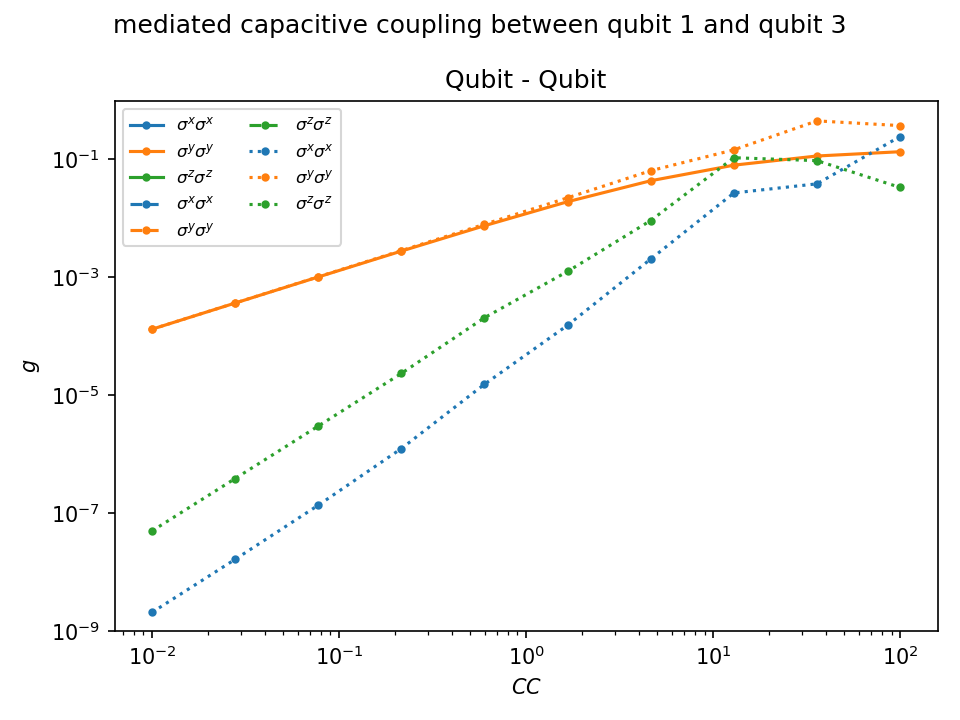

In [118]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

for i, Pauli in enumerate(Pauli_list):
    # if i ==1: 
    #     continue
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    ax.plot(CC_values, σxσx,'.', color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(CC_values, σyσy,'.', color = colors[1], linestyle=linestyles[i], label = labels[1])
    ax.plot(CC_values, σzσz,'.', color = colors[2], linestyle=linestyles[i], label = labels[2])

    ax.legend(ncol=2, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e-9,1e0])
    # ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel('$CC$')
    
    ax.set_title(name)
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

# Direct method

In [20]:
n_eig = 4

In [102]:
p1  = np.zeros([len(CC_values), 4, 4])
p2  = np.zeros([len(CC_values), 4, 4])
SWT = np.zeros([len(CC_values), 4, 4])

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)

    C_mat = sq_ext.C_mat_qubit_C_qubit(CC, CR_1, CF_1, CR_2, CF_2, only_inner=True, compensate_extra_cap=False, only_renormalization=False)
    C_inv = np.linalg.inv(C_mat)
    
    fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f, φ_ext = φ_ext_1)
    resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext = φ_ext_2)
    resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
    
    H_f1 = fluxonium_1.hamiltonian()
    H_r1 = resonator_1.hamiltonian()
    H_f2 = fluxonium_2.hamiltonian()
    H_r2 = resonator_2.hamiltonian()

    I_f = qt.identity(H_f1.shape[0])
    I_r = qt.identity(H_r1.shape[0])
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2]
    Δs = [Δ_1, Δ_2]
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_circuits(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
    
    # subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_0, H_fluxonium=H_f1, H_resonator=H_f2, n_eig=n_eig)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
    
    
    H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real=True, remove_ground=True)
    H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real=True, remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real=True, remove_ground=True)

    
    H_eff_p1 = H_eff_p1  [subspace_indices][:, subspace_indices]
    H_eff_p2 = H_eff_p2  [subspace_indices][:, subspace_indices]
    H_eff_SWT= H_eff_SWT [subspace_indices][:, subspace_indices]

    
    
    p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
    p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
    SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)

0
1
2
3
4
5
6
7
8
9


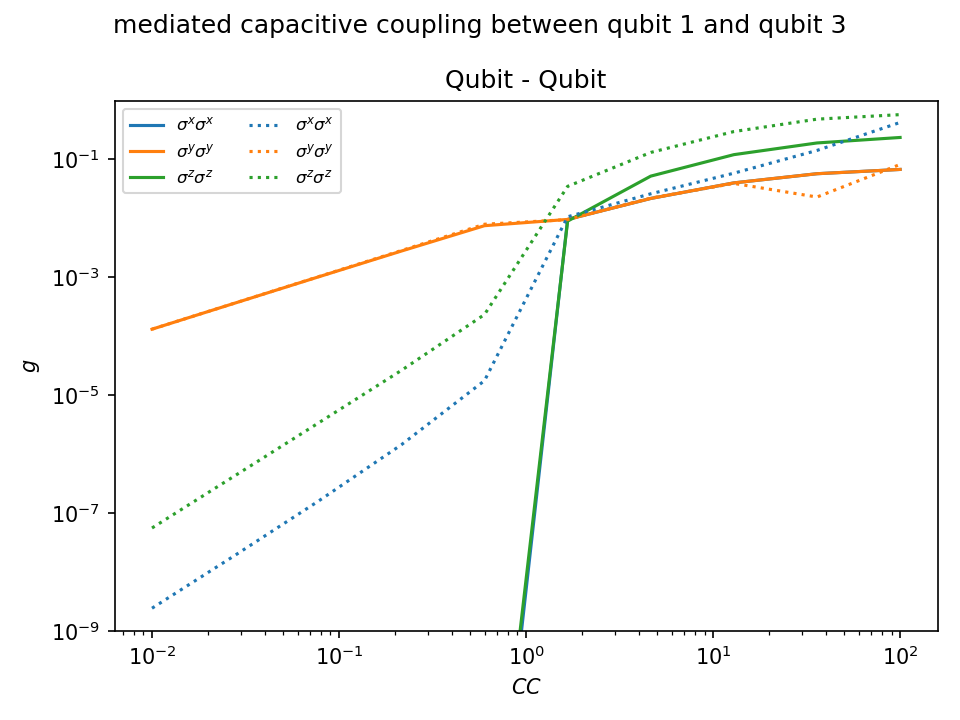

In [103]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

for i, Pauli in enumerate(Pauli_list):
    if i ==1: 
        continue
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    ax.plot(CC_values, σxσx,  color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(CC_values, σyσy,  color = colors[1], linestyle=linestyles[i], label = labels[1])
    ax.plot(CC_values, σzσz,  color = colors[2], linestyle=linestyles[i], label = labels[2])

    ax.legend(ncol=2, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e-9,1e0])
    # ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel('$CC$')
    
    ax.set_title(name)
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

## Qubit-C-Qubit-C-Qubit vs CC

In [51]:
Δs = [Δ_1, Δ_2, Δ_3]
nmax_f = 7
nmax_r = 4

In [52]:
p1  = np.zeros([len(CC_values), 4, 4])
p2  = np.zeros([len(CC_values), 4, 4])
SWT = np.zeros([len(CC_values), 4, 4])

g_13_analytic =np.zeros(len(CC_values))

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)

    C_mat = sq_ext.C_mat_qubit_C_qubit_C_qubit(CC, CF_1, CR_1, CF_2, CR_2, CF_3, CR_3)
    C_inv = np.linalg.inv(C_mat)
    
    fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
    resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f)
    resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
    fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
    resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2, fluxonium_3, resonator_3]
    H_circuits = [circuit.hamiltonian() for circuit in circuits]
    
    I_f = qt.identity(nmax_f)
    I_r = qt.identity(nmax_r)
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_C_qubit(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
    
    H_qubit_1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δ_1 )
    H_qubit_2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δ_2 )
    H_qubit_3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δ_3 )
    
    # Composite method
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_1, H_fluxonium=H_circuits[0], H_resonator=H_circuits[1], n_eig=2)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q1 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q1 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_2, H_fluxonium=H_circuits[2], H_resonator=H_circuits[3], n_eig=2)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q2 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q2 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]
    
    Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_3, H_fluxonium=H_circuits[4], H_resonator=H_circuits[5], n_eig=2)
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q3 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q3 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

    ψ_00_q1 = qt.Qobj(sq_ext.diag(H_qubit_1,n_eig=4,solver='numpy')[1][:,index_00_q1]) 
    ψ_10_q1 = qt.Qobj(sq_ext.diag(H_qubit_1,n_eig=4,solver='numpy')[1][:,index_10_q1]) 
    ψ_00_q2 = qt.Qobj(sq_ext.diag(H_qubit_2,n_eig=4,solver='numpy')[1][:,index_00_q2]) 
    # ψ_10_q2 = qt.Qobj(sq_ext.diag(H_qubit_2,n_eig=4,solver='numpy')[1][:,index_10_q2]) 
    ψ_00_q3 = qt.Qobj(sq_ext.diag(H_qubit_3,n_eig=4,solver='numpy')[1][:,index_00_q3]) 
    ψ_10_q3 = qt.Qobj(sq_ext.diag(H_qubit_3,n_eig=4,solver='numpy')[1][:,index_10_q3]) 
    
    ψ_00_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_00_q2.dims = [[nmax_f, nmax_r],[1,1]]
    # ψ_10_q2.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_00_q3.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q3.dims = [[nmax_f, nmax_r],[1,1]]
    
    ψ_00 = qt.tensor([ψ_00_q1, ψ_00_q2, ψ_00_q3])
    ψ_01 = qt.tensor([ψ_10_q1, ψ_00_q2, ψ_00_q3])
    ψ_10 = qt.tensor([ψ_00_q1, ψ_00_q2, ψ_10_q3])
    ψ_11 = qt.tensor([ψ_10_q1, ψ_00_q2, ψ_10_q3])

    ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]

    E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
    E_0  = sq_ext.diag(H_0 , n_eig=len(ψ_0)+5, out='GHz', solver='scipy')[0]
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)

    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+5, out='GHz', solver='Qutip', qObj=True)
    ψ = ψ[subspace_indices]
    E = E[subspace_indices]
    # V = H-H_0
    
    # print('Punto de control 1')
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
    # H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True)

    p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
    # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
    SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)
    
    # 
    # # Direct method
    # H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real=True, remove_ground=True)
    # # H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real=True, remove_ground=True)
    # H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real=True, remove_ground=True)
    # 
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_0_basis, H_circuits[0], H_circuits[4], n_eig=6)
    # subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
    # 
    # H_eff_p1_subspace   = H_eff_p1  [subspace_indices][:, subspace_indices]
    # # H_eff_p2_subspace   = H_eff_p2  [subspace_indices][:, subspace_indices]
    # H_eff_SWT_subspace  = H_eff_SWT [subspace_indices][:, subspace_indices]
    # 
    # p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1_subspace  ,  print_pretty=False)
    # # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2_subspace  ,  print_pretty=False)
    # SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT_subspace , print_pretty=False)
    
    #Analytics:
    E_1 = fluxonium_1.diag(2)[0]
    E_2 = fluxonium_2.diag(2)[0]
    E_3 = fluxonium_3.diag(2)[0]
    
    ω_1 = E_1[1]- E_1[0]
    ω_2 = E_2[1]- E_2[0]
    ω_3 = E_3[1]- E_3[0]
    
    Q_1 = np.abs(fluxonium_1.charge_op(0, basis='eig')[0,1])
    Q_2 = np.abs(fluxonium_2.charge_op(0, basis='eig')[0,1])
    Q_3 = np.abs(fluxonium_3.charge_op(0, basis='eig')[0,1])

    Δ_12 = -np.abs(ω_1 - ω_2) # maybe change sign
    Δ_23 = -np.abs(ω_3 - ω_2) 
    Σ_12 = ω_1 + ω_2
    Σ_23 = ω_3 + ω_2

    g_12 = C_inv[0,2] * fF**-1 * Q_1 * Q_2 /2/np.pi/GHz
    g_23 = C_inv[2,4] * fF**-1 * Q_2 * Q_3 /2/np.pi/GHz
    g_13 = C_inv[0,4] * fF**-1 * Q_1 * Q_3 /2/np.pi/GHz

    g_eff = g_12*g_23*(1/Δ_12 + 1/Δ_23 - 1/Σ_12-1/Σ_23) + g_13

    g_13_analytic[i] = g_eff
    

0


C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:901: ComplexWarning: Casting complex values to real discards the imaginary part
  H_eff[i, j] = (ψ_0[i].dag() * H * ψ_0[j]).data[0, 0]
C:\Users\gabri\PycharmProjects\tunable-capacitive-coupling-flux-qubits\Modules\SQcircuit_extensions.py:1519: ComplexWarning: Casting complex values to real discards the imaginary part
  P[i, j] = 0.25 * (np.dot(S.T.conjugate(), A)).trace() # P[i,j]=(1/4)tr(S_ij^t*A)


1
2
3
4
5
6
7
8
9


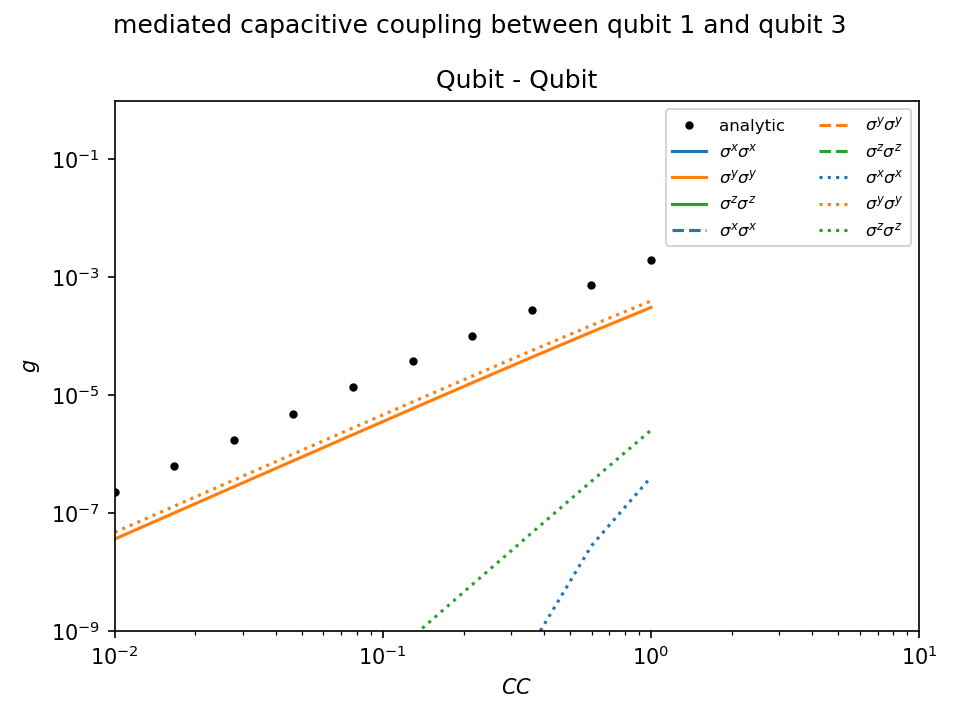

In [56]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

ax.plot(CC_values, np.abs(g_13_analytic),  '.k', label = 'analytic')

for i, Pauli in enumerate(Pauli_list):
    if i ==1: 
        Pauli /= GHz
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    ax.plot(CC_values, σxσx,  color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(CC_values, σyσy,  color = colors[1], linestyle=linestyles[i], label = labels[1])
    ax.plot(CC_values, σzσz,  color = colors[2], linestyle=linestyles[i], label = labels[2])

    ax.legend(ncol=2, fontsize=8)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_ylim([1e-9,1e0])
    ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel('$CC$')
    
    ax.set_title(name)
    
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()

In [45]:
g_13_analytic =np.zeros(len(CC_values))

g_r_limit =np.zeros(len(CC_values))
g_fq_limit=np.zeros(len(CC_values))

for i, CC in enumerate(CC_values):
    print(i)
    C_mat = sq_ext.C_mat_qubit_C_qubit_C_qubit(CC, CF_1, CR_1, CF_2, CR_2, CF_3, CR_3)
    C_inv = np.linalg.inv(C_mat)
    fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
    resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f)
    resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
    fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
    resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)
    E_1 = fluxonium_1.diag(2)[0]
    E_2 = fluxonium_2.diag(2)[0]
    E_3 = fluxonium_3.diag(2)[0]
    
    ω_1 = E_1[1]- E_1[0]
    ω_2 = E_2[1]- E_2[0]
    ω_3 = E_3[1]- E_3[0]
    
    Q_1 = np.abs(fluxonium_1.charge_op(0, basis='eig')[0,1])
    Q_2 = np.abs(fluxonium_2.charge_op(0, basis='eig')[0,1])
    Q_3 = np.abs(fluxonium_3.charge_op(0, basis='eig')[0,1])
    # print(Q_1, Q_2, Q_3)
    # 
    Δ_12 = -np.abs(ω_1 - ω_2) # maybe change sign
    Δ_23 = -np.abs(ω_3 - ω_2) 
    Σ_12 = ω_1 + ω_2
    Σ_23 = ω_3 + ω_2
    # print(Δ_12,Δ_23,Σ_12,Σ_23)
    # 
    g_12 = C_inv[0,2] * fF**-1 * Q_1 * Q_2 /2/np.pi/GHz
    g_23 = C_inv[2,4] * fF**-1 * Q_2 * Q_3 /2/np.pi/GHz
    g_13 = C_inv[0,4] * fF**-1 * Q_1 * Q_3 /2/np.pi/GHz
    # print(g_12,g_23,g_13)
    g_eff = g_12*g_23*(1/Δ_12 + 1/Δ_23 - 1/Σ_12-1/Σ_23) + g_13
    # print(g_eff)
    g_13_analytic[i] = g_eff

0
1
2
3
4
5
6
7
8
9


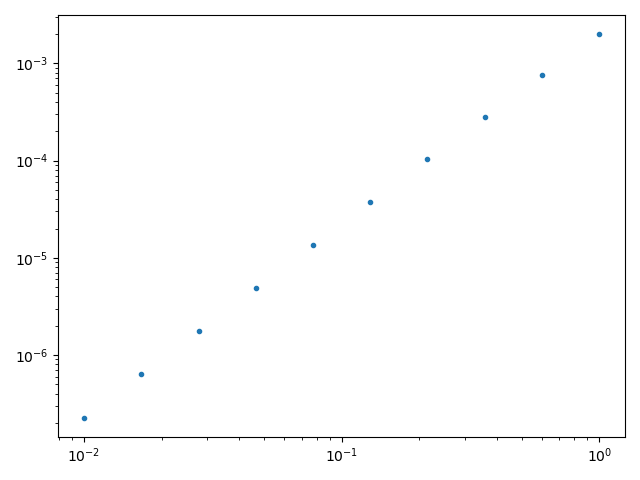

In [50]:
fig, ax = plt.subplots()

ax.plot(CC_values,np.abs(g_13_analytic), '.')
ax.set_yscale('log')
ax.set_xscale('log')
fig.tight_layout()
fig.show()

## Qubit-C-Qubit-C-Qubit vs phi_ext

In [96]:
Δs = [Δ_1, Δ_2, Δ_3]
nmax_f = 7
nmax_r = 3
φ_ext_2_values = np.linspace(0.51,0.53,100)
CC = 1
n_eig_circuits=2
n_eig_qubit=4

In [97]:
p1  = np.zeros([len(φ_ext_2_values), 4, 4])
p2  = np.zeros([len(φ_ext_2_values), 4, 4])
SWT = np.zeros([len(φ_ext_2_values), 4, 4])

g_13_analytic =np.zeros(len(φ_ext_2_values))
g_r_limit =np.zeros(len(φ_ext_2_values))
g_fq_limit=np.zeros(len(φ_ext_2_values))

C_mat = sq_ext.C_mat_qubit_C_qubit_C_qubit(CC, CF_1, CR_1, CF_2, CR_2, CF_3, CR_3)
C_inv = np.linalg.inv(C_mat)

fluxonium_1 = sq_ext.sq_fluxonium(C_F_eff=C_inv[0, 0] ** -1, L_F_eff = LF_1, EJ=EJ_1, nmax_f=nmax_f)
resonator_1 = sq_ext.sq_resonator(C_R_eff=C_inv[1, 1] ** -1, L_R_eff = LR_1, nmax_r=nmax_r)
resonator_2 = sq_ext.sq_resonator(C_R_eff=C_inv[3, 3] ** -1, L_R_eff = LR_2, nmax_r=nmax_r)
fluxonium_3 = sq_ext.sq_fluxonium(C_F_eff=C_inv[4, 4] ** -1, L_F_eff = LF_3, EJ=EJ_3, nmax_f=nmax_f)
resonator_3 = sq_ext.sq_resonator(C_R_eff=C_inv[5, 5] ** -1, L_R_eff = LR_3, nmax_r=nmax_r)

φ_ext_3_resonance = sq_ext.find_resonance(fluxonium_1.hamiltonian(), fluxonium_3)
loop_3 = fluxonium_3.loops[0]
loop_3.set_flux(φ_ext_3_resonance)


for i, φ_ext_2 in enumerate(φ_ext_2_values):
    print(i)
    
    fluxonium_2 = sq_ext.sq_fluxonium(C_F_eff=C_inv[2, 2] ** -1, L_F_eff = LF_2, EJ=EJ_2, nmax_f=nmax_f, φ_ext=φ_ext_2)

    # ω_1 = sq_ext.diag(fluxonium_1.hamiltonian(),2,remove_ground=True)[0][1]
    # ω_2 = sq_ext.diag(fluxonium_2.hamiltonian(),2,remove_ground=True)[0][1]
    # ω_3 = sq_ext.diag(fluxonium_3.hamiltonian(),2,remove_ground=True)[0][1]
    # print(ω_1,ω_2, ω_3)
    
    circuits = [fluxonium_1, resonator_1, fluxonium_2, resonator_2, fluxonium_3, resonator_3]
    H_circuits = [circuit.hamiltonian() for circuit in circuits]
    
    H_0, H   = sq_ext.hamiltonian_qubit_C_qubit_C_qubit(C_inv, circuits, Δs, nmax_r=nmax_r, nmax_f=nmax_f, return_H_0=True)
    
    H_qubit_1 = sq_ext.hamiltonian_qubit(fluxonium_1, resonator_1, Δ_1 )
    H_qubit_2 = sq_ext.hamiltonian_qubit(fluxonium_2, resonator_2, Δ_2 )
    H_qubit_3 = sq_ext.hamiltonian_qubit(fluxonium_3, resonator_3, Δ_3 )
    
    E_q1, ψ_q1 = sq_ext.diag(H_qubit_1, n_eig_qubit, solver='numpy')
    E_q2, ψ_q2 = sq_ext.diag(H_qubit_2, n_eig_qubit, solver='numpy')
    E_q3, ψ_q3 = sq_ext.diag(H_qubit_3, n_eig_qubit, solver='numpy')
    
    E_circuits = [sq_ext.diag(H, n_eig_circuits, solver='numpy')[0] for H in H_circuits]
    
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_1, H_fluxonium=H_circuits[0], H_resonator=H_circuits[1], n_eig=2)
    Nf, Nr = sq_ext.sq_get_energy_indices(E_q1, E_circuits[0], E_circuits[1])
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q1 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q1 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]
    
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_2, H_fluxonium=H_circuits[2], H_resonator=H_circuits[3], n_eig=2)
    Nf, Nr = sq_ext.sq_get_energy_indices(E_q2, E_circuits[2], E_circuits[3])
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q2 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q2 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]
    
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_qubit = H_qubit_3, H_fluxonium=H_circuits[4], H_resonator=H_circuits[5], n_eig=2)
    Nf, Nr = sq_ext.sq_get_energy_indices(E_q3, E_circuits[4], E_circuits[5])
    subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr==0)).tolist()
    index_00_q3 = np.intersect1d(np.where(Nf==0), np.where(Nr==0)).tolist()[0]
    index_10_q3 = np.intersect1d(np.where(Nf==1), np.where(Nr==0)).tolist()[0]

    ψ_00_q1 = qt.Qobj(ψ_q1[:,index_00_q1]) 
    ψ_10_q1 = qt.Qobj(ψ_q1[:,index_10_q1]) 
    ψ_00_q2 = qt.Qobj(ψ_q2[:,index_00_q2]) 
    ψ_10_q2 = qt.Qobj(ψ_q2[:,index_10_q2]) 
    ψ_00_q3 = qt.Qobj(ψ_q3[:,index_00_q3]) 
    ψ_10_q3 = qt.Qobj(ψ_q3[:,index_10_q3]) 
    
    ψ_00_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q1.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_00_q2.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q2.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_00_q3.dims = [[nmax_f, nmax_r],[1,1]]
    ψ_10_q3.dims = [[nmax_f, nmax_r],[1,1]]
    
    ψ_00 = qt.tensor([ψ_00_q1, ψ_00_q2, ψ_00_q3])
    ψ_01 = qt.tensor([ψ_10_q1, ψ_00_q2, ψ_00_q3])
    ψ_10 = qt.tensor([ψ_00_q1, ψ_00_q2, ψ_10_q3])
    ψ_11 = qt.tensor([ψ_10_q1, ψ_00_q2, ψ_10_q3])

    ψ_0 = [ψ_00,ψ_01,ψ_10,ψ_11]

    E_0_ψ_0  = [ np.real((ψ_0_i.dag() * H_0 * ψ_0_i).data[0,0])/2/np.pi/GHz for ψ_0_i in ψ_0]
    E_0  = sq_ext.diag(H_0 , n_eig=len(ψ_0)+6, out='GHz', solver='scipy')[0]
    subspace_indices = sq_ext.find_close_indices(E_0_ψ_0, E_0)
    print(E_0_ψ_0, E_0)
    print(subspace_indices)
    print('/n')

    E, ψ = sq_ext.diag(H  , n_eig=len(ψ_0)+6, out='GHz', solver='Qutip', qObj=True)
    ψ = ψ[subspace_indices]
    E = E[subspace_indices]
    # V = H-H_0
    
    # print('Punto de control 1')
    H_eff_p1  = sq_ext.H_eff_p1_large (ψ_0, H, real=True, remove_ground=True)
    # H_eff_p2  = sq_ext.H_eff_p2_large (ψ_0, ψ, E_0, E, V,  remove_ground=True)
    H_eff_SWT = sq_ext.H_eff_SWT_large(ψ_0, ψ, E, remove_ground=True)

    p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1  ,  print_pretty=False)
    # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2  ,  print_pretty=False)
    SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT , print_pretty=False)
    
    # Analytic

    
    E_1 = sq_ext.diag(H_qubit_1,2)[0]
    E_2 = sq_ext.diag(H_qubit_2,2)[0]
    E_3 = sq_ext.diag(H_qubit_3,2)[0]
    fluxonium_1.diag(2)[0];
    fluxonium_2.diag(2)[0];
    fluxonium_3.diag(2)[0];
    Q_1 = np.abs(fluxonium_1.charge_op(0, basis='eig')[0,1])
    Q_2 = np.abs(fluxonium_2.charge_op(0, basis='eig')[0,1])
    Q_3 = np.abs(fluxonium_3.charge_op(0, basis='eig')[0,1])
    
    ω_1 = E_1[1]- E_1[0]
    ω_2 = E_2[1]- E_2[0]
    ω_3 = E_3[1]- E_3[0]
    

    Δ_12 = -np.abs(ω_1 - ω_2) # maybe change sign
    Δ_23 = -np.abs(ω_3 - ω_2) 
    Σ_12 = ω_1 + ω_2
    Σ_23 = ω_3 + ω_2

    g_12 = C_inv[0,2] * fF**-1 * Q_1 * Q_2 /2/np.pi/GHz
    g_23 = C_inv[2,4] * fF**-1 * Q_2 * Q_3 /2/np.pi/GHz
    g_13 = C_inv[0,4] * fF**-1 * Q_1 * Q_3 /2/np.pi/GHz

    g_eff = g_12*g_23*(1/Δ_12 + 1/Δ_23 - 1/Σ_12-1/Σ_23) + g_13

    g_13_analytic[i] = g_eff
    
    # 
    # # Direct method
    # H_eff_p1  = sq_ext.H_eff_p1 (H_0, H, n_eig, real=True, remove_ground=True)
    # # H_eff_p2  = sq_ext.H_eff_p2 (H_0, H, n_eig, real=True, remove_ground=True)
    # H_eff_SWT = sq_ext.H_eff_SWT(H_0, H, n_eig, real=True, remove_ground=True)
    # 
    # Nf, Nr = sq_ext.sq_get_energy_indices_hamiltonian(H_0_basis, H_circuits[0], H_circuits[4], n_eig=6)
    # subspace_indices = np.intersect1d(np.where(Nf<=1), np.where(Nr<=1)).tolist()
    # 
    # H_eff_p1_subspace   = H_eff_p1  [subspace_indices][:, subspace_indices]
    # # H_eff_p2_subspace   = H_eff_p2  [subspace_indices][:, subspace_indices]
    # H_eff_SWT_subspace  = H_eff_SWT [subspace_indices][:, subspace_indices]
    # 
    # p1 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p1_subspace  ,  print_pretty=False)
    # # p2 [i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_p2_subspace  ,  print_pretty=False)
    # SWT[i,:] = sq_ext.decomposition_in_pauli_4x4(H_eff_SWT_subspace , print_pretty=False)

0
[15.104710311140826, 18.767927570716445, 18.733847382309023, 22.397064641884437] [15.104710311141 18.555341483245 18.733847382309 18.767927570717 20.306610674825 21.155329358709 21.472635245354 22.184478554413 22.218558742821 22.397064641885]
[0, 3, 2, 9]
/n
1
[15.102380485769606, 18.765597745345165, 18.731517556937813, 22.394734816513218] [15.102380485770 18.556235773274 18.731517556938 18.765597745346 20.304280849454 21.152999823663 21.470305419982 22.185372844442 22.219453032849 22.394734816513]
[0, 3, 2, 9]
/n
2
[15.100006351885398, 18.76322361146103, 18.729143423053557, 22.39236068262902] [15.100006351886 18.557145529818 18.729143423054 18.763223611461 20.301906715569 21.150625993281 21.467931286098 22.186282600986 22.220362789394 22.392360682629]
[0, 3, 2, 9]
/n
3
[15.097588038163034, 18.76080529773856, 18.726725109331124, 22.38994236890663] [15.097588038163 18.558070616698 18.726725109331 18.760805297739 20.299488401847 21.148207996638 21.465512972376 22.187207687866 22.221287

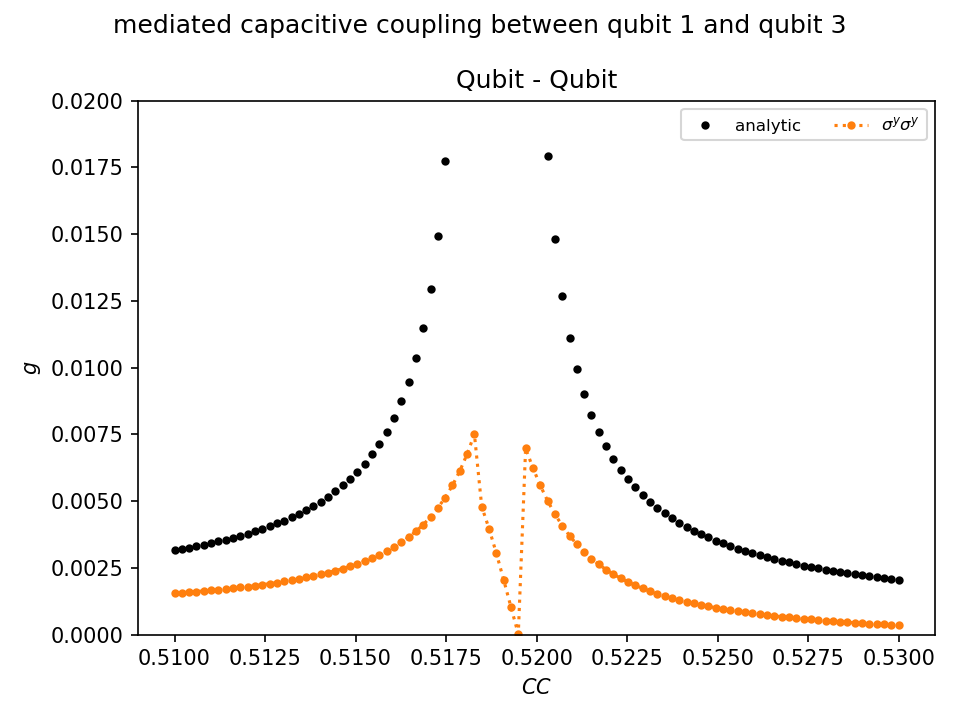

In [99]:
fig, ax = plt.subplots(dpi=150)
linestyles = ['-', '--',':' ]
names = ['Qubit - Qubit','Qubit - Resonator','Resonator - Resonator']
labels_list =[[r'$\sigma^x\sigma^x$',r'$\sigma^y\sigma^y$',r'$\sigma^z\sigma^z$'],
              [r'$\sigma^x\,(b^\dagger+b)$',r'$\sigma^y\,(b^\dagger-b)j$',r'$\sigma^z(2b^\dagger b-I)$'],
              [r'$(a^\dagger+a)\,(b^\dagger+b)$',r'$(a^\dagger-a)j\,(b^\dagger-b)j$',r'$(2a^\dagger a-I)(2b^\dagger b-I)$']]

labels = labels_list[0]
name = names[0]
colors = figs.generate_colors_from_colormap(10, 'tab10')
Pauli_list = [p1, p2, SWT]

ax.plot(φ_ext_2_values, np.abs(g_13_analytic),  '.k', label = 'analytic')

for i, Pauli in enumerate(Pauli_list):
    if i ==1 or i ==0: 
        continue
        Pauli /= GHz
    
    σxσx = np.abs(Pauli[:, 1,1])
    σyσy = np.abs(Pauli[:, 2,2])
    σzσz = np.abs(Pauli[:, 3,3])

    # ax.plot(φ_ext_2_values, σxσx, '.' , color = colors[0], linestyle=linestyles[i], label = labels[0])
    ax.plot(φ_ext_2_values, σyσy, '.' , color = colors[1], linestyle=linestyles[i], label = labels[1])
    # ax.plot(φ_ext_2_values, (σyσy/np.abs(g_13_analytic))**-1, '.' , color = colors[1], linestyle=linestyles[i], label = labels[1])
    # ax.plot(φ_ext_2_values, σzσz, '.' , color = colors[2], linestyle=linestyles[i], label = labels[2])
    
    ax.legend(ncol=2, fontsize=8)
    # ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_ylim([0,0.02])
    # ax.set_xlim([1e-2,1e1])
    ax.set_ylabel('$g$')
    ax.set_xlabel('$CC$')
    
    ax.set_title(name)
    
fig.suptitle(r'mediated capacitive coupling between qubit 1 and qubit 3')
fig.tight_layout()
# figs.export('mediated_capacitive_coupling_vs_CC_qubit_1_and_qubit_3.pdf', fig)
fig.show()